# 7-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

---

## **목차**

Step1.[데이터 준비와 확인](#Step1.-데이터-준비와-확인)  
Step2.[데이터로더 구성](#Step2.-데이터로더-구성)  
Step3.[모델구성을 위한 데이터 분석 및 가공](#Step3.-모델구성을-위한-데이터-분석-및-가공)  
Step4.[모델구성 및 validation set 구성](#Step4.-모델구성-및-validation-set-구성)  
Step5.[모델 훈련 개시](#Step5.-모델-훈련-개시)  
Step6.[Loss, Accuracy 그래프 시각화](#Step6.-Loss,-Accuracy-그래프-시각화)  
Step7.[학습된 Embedding 레이어 분석](#Step7.-학습된-Embedding-레이어-분석)  
Step8.[한국어 Word2Vec 임베딩 활용하여 성능개선](#Step8.-한국어-Word2Vec-임베딩-활용하여-성능개선)  
⭐[루브릭 관련 고려한 점](#루브릭-관련-고려한-점)  
🙋[회고](#회고)


---

## Step 1. 데이터 준비와 확인

- 네이버 영화리뷰 데이터를 [다운로드](https://github.com/e9t/nsmc) 받습니다.

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 0번이 부정적인 리뷰, 1번이 긍정적인 리뷰로 분류함을 알 수 있다.

## Step 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [3]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [5]:
# {텍스트: 인덱스}에서 {인덱스:텍스트}로 변경

index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## Step 3. 모델구성을 위한 데이터 분석 및 가공

In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- 처음에 maxlen의 값을 높였을 때 전체 문장이 maxlen 설정값 이내에 포함되는 값이 클 수록 좋은 것이라고 생각했다.
- 다만 문장길이가 너무 긴 이상치를 가진 데이터를 제거하고 학습하는 것이 더 효율적이라고 판단하여 maxlen을 int(평균 + 2*표준편차)로 지정하였다.

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [10]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

## Step 4. 모델구성 및 validation set 구성

In [11]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 41 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

### 1. GlobalMaxPooling1D

In [12]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


### 2. LSTM

In [13]:
model2 = keras.Sequential(name='LSTM')
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


### 3. Convolution Neural Network(1-D CNN) 모델

In [14]:
model3 = keras.Sequential(name='CNN')
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.MaxPooling1D(5))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9       

In [15]:
# validation set 구성

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=7)

## Step 5. 모델 훈련 개시

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [17]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 9ms/step - loss: 0.6148 - accuracy: 0.7260 - val_loss: 0.3876 - val_accuracy: 0.8317
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3449 - accuracy: 0.8539 - val_loss: 0.3576 - val_accuracy: 0.8453
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2936 - accuracy: 0.8799 - val_loss: 0.3564 - val_accuracy: 0.8481
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2587 - accuracy: 0.8965 - val_loss: 0.3625 - val_accuracy: 0.8479
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2322 - accuracy: 0.9089 - val_loss: 0.3733 - val_accuracy: 0.8467
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2085 - accuracy: 0.9212 - val_loss: 0.3902 - val_accuracy: 0.8435
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.1887 - accuracy: 0.9300 - val_loss: 0.4086 - val_accuracy: 0.8419
Epoch 

In [18]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 6s 15ms/step - loss: 0.6106 - accuracy: 0.6683 - val_loss: 0.3937 - val_accuracy: 0.8383
Epoch 2/20
229/229 [==============================] - 3s 13ms/step - loss: 0.3517 - accuracy: 0.8592 - val_loss: 0.3603 - val_accuracy: 0.8456
Epoch 3/20
229/229 [==============================] - 3s 13ms/step - loss: 0.3052 - accuracy: 0.8751 - val_loss: 0.3532 - val_accuracy: 0.8473
Epoch 4/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2892 - accuracy: 0.8815 - val_loss: 0.3599 - val_accuracy: 0.8447
Epoch 5/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2736 - accuracy: 0.8886 - val_loss: 0.3596 - val_accuracy: 0.8456
Epoch 6/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2603 - accuracy: 0.8937 - val_loss: 0.3671 - val_accuracy: 0.8476
Epoch 7/20
229/229 [==============================] - 3s 13ms/step - loss: 0.2470 - accuracy: 0.8986 - val_loss: 0.3774 - val_accuracy: 0.8466

In [19]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 9s 26ms/step - loss: 0.5829 - accuracy: 0.6954 - val_loss: 0.3634 - val_accuracy: 0.8418
Epoch 2/20
229/229 [==============================] - 2s 11ms/step - loss: 0.3187 - accuracy: 0.8655 - val_loss: 0.3524 - val_accuracy: 0.8499
Epoch 3/20
229/229 [==============================] - 2s 11ms/step - loss: 0.2717 - accuracy: 0.8893 - val_loss: 0.3478 - val_accuracy: 0.8527
Epoch 4/20
229/229 [==============================] - 2s 11ms/step - loss: 0.2295 - accuracy: 0.9116 - val_loss: 0.3604 - val_accuracy: 0.8530
Epoch 5/20
229/229 [==============================] - 2s 11ms/step - loss: 0.1814 - accuracy: 0.9352 - val_loss: 0.3979 - val_accuracy: 0.8467
Epoch 6/20
229/229 [==============================] - 2s 11ms/step - loss: 0.1351 - accuracy: 0.9534 - val_loss: 0.4512 - val_accuracy: 0.8414
Epoch 7/20
229/229 [==============================] - 2s 11ms/step - loss: 0.0981 - accuracy: 0.9688 - val_loss: 0.5153 - val_accuracy: 0.8325

In [20]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.5528 - accuracy: 0.8301
1537/1537 - 5s - loss: 0.4404 - accuracy: 0.8430
1537/1537 - 4s - loss: 0.8612 - accuracy: 0.8237


- 같은 조건 하에 두번째 모델이 가장 좋은성능을 보였다.
- 다만 정확도가 높지 않아고 85%에 미치지 못하기에 개선이 필요하다.
- EarlyStopping 여부도 함께 체크해봤을 시 효과적이기에 사용하기로 했다.

## Step 6.  Loss, Accuracy 그래프 시각화

In [21]:
import matplotlib.pyplot as plt

history1_dict = history1.history
history2_dict = history2.history
history3_dict = history3.history

print(history1_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

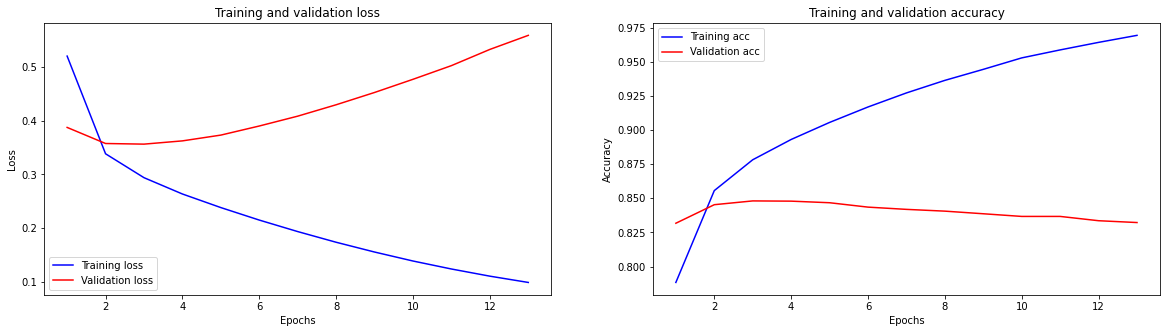

In [22]:
# GlobalMaxPooling1D 그래프

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf() 

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

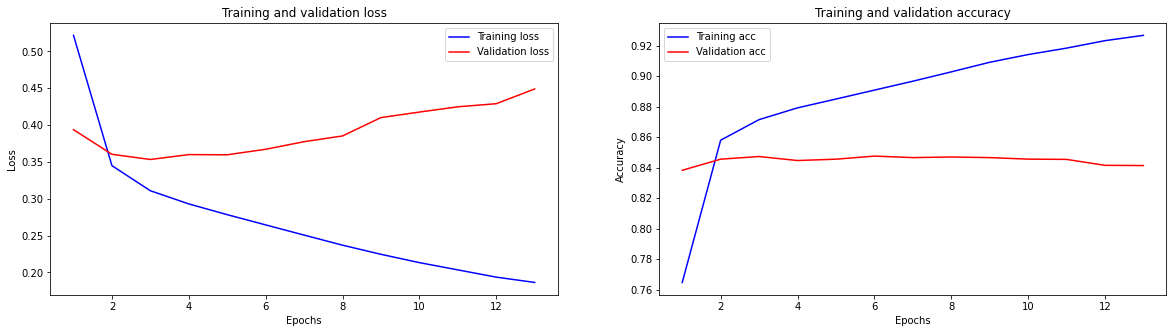

In [23]:
# LSTM 그래프

acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

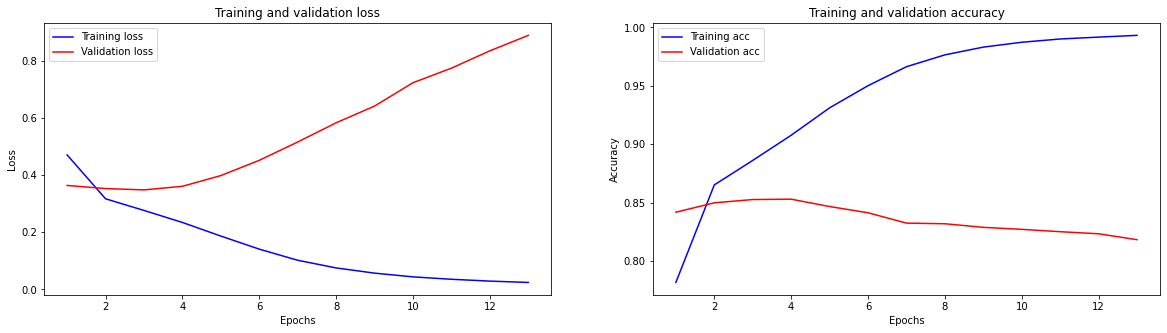

In [24]:
# CNN 그래프

acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 7. 학습된 Embedding 레이어 분석

In [25]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 41)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [28]:
vector = word_vectors['만족']
vector

array([-0.17540331,  0.01936781, -0.12122182, -0.15617381, -0.1557555 ,
       -0.21536486,  0.05101965,  0.06970357,  0.09828575, -0.09997368,
        0.03230062,  0.07167607,  0.02967365, -0.00439998, -0.11673175,
        0.06670161,  0.06522508,  0.10033584,  0.07502158,  0.1033807 ,
        0.01781492, -0.12074099, -0.12642819, -0.05338813,  0.18312377,
        0.00634271, -0.0684524 ,  0.04824747,  0.19214259, -0.02891331,
       -0.13643026, -0.02496109, -0.00747726,  0.06048567,  0.01455396,
       -0.06023627, -0.2801669 , -0.04051591, -0.05354789,  0.02644337,
       -0.15188417], dtype=float32)

In [29]:
word_vectors.similar_by_word("놀람")

[('아픕니다', 0.9140501022338867),
 ('꽁', 0.9072076082229614),
 ('-_', 0.8978961110115051),
 ('친다', 0.8955138325691223),
 ('_-', 0.8885351419448853),
 ('로봇', 0.8842756152153015),
 ('..!!', 0.8842747211456299),
 ('울려', 0.8836635947227478),
 ('컴', 0.8816976547241211),
 ('극치', 0.8774944543838501)]

## Step 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

한국어 Word2Vec은 다음 [경로](https://github.com/Kyubyong/wordvectors)에서 구할 수 있습니다.  

In [30]:
from gensim.models import Word2Vec

In [31]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [32]:
word2vec = Word2Vec.load(word2vec_path)

In [33]:
vector = word2vec['사랑']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [70]:
# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.LSTM(512))
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_24 (LSTM)               (None, 512)               1460224   
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 4104      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [71]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 39s 162ms/step - loss: 0.5528 - accuracy: 0.7105 - val_loss: 0.3677 - val_accuracy: 0.8378
Epoch 2/20
229/229 [==============================] - 37s 161ms/step - loss: 0.3255 - accuracy: 0.8595 - val_loss: 0.3284 - val_accuracy: 0.8585
Epoch 3/20
229/229 [==============================] - 37s 162ms/step - loss: 0.2682 - accuracy: 0.8877 - val_loss: 0.3261 - val_accuracy: 0.8601
Epoch 4/20
229/229 [==============================] - 37s 162ms/step - loss: 0.2277 - accuracy: 0.9077 - val_loss: 0.3216 - val_accuracy: 0.8652
Epoch 5/20
229/229 [==============================] - 37s 162ms/step - loss: 0.1862 - accuracy: 0.9261 - val_loss: 0.3450 - val_accuracy: 0.8632
Epoch 6/20
229/229 [==============================] - 37s 163ms/step - loss: 0.1454 - accuracy: 0.9441 - val_loss: 0.3874 - val_accuracy: 0.8620
Epoch 7/20
229/229 [==============================] - 38s 164ms/step - loss: 0.1068 - accuracy: 0.9607 - val_loss: 0.4248 - val_ac

In [72]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 12s - loss: 0.8016 - accuracy: 0.8568


<Figure size 432x288 with 0 Axes>

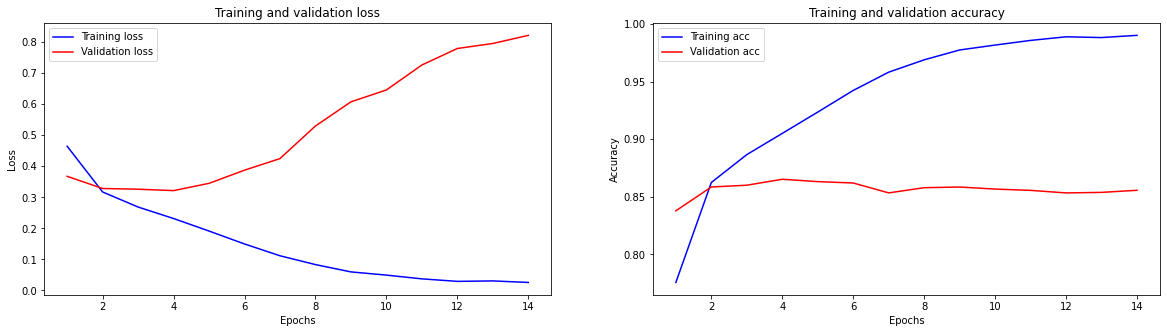

In [74]:
# 한국어 Word2Vec 임베딩 활용한 모델 그래프

history4_dict = history4.history

acc = history4_dict['accuracy']
val_acc = history4_dict['val_accuracy']
loss = history4_dict['loss']
val_loss = history4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

## 루브릭 관련 고려한 점

**1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**

- 3가지 이상의 모델을 성공적으로 시도함
    

**2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**

- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

**3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**

- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 회고

1️⃣ 잘한 점:  
- 포기하지 않고 계속 시도 했다.
- 나눠져있던 그래프를 모아서 한눈에 볼 수 있게 시각화했다.

2️⃣ 어려웠던 점:
- ko.bin 불러오는데서 계속 에러가 났다.
- 처음에는 언피클링 에러가 나서 해결하려고 검색해서 시키는 코드도 써보고 이것저것 시도해봤지만 실패했다.
- 아지트에 올라와있는 버전 다운그레이드 관련 이슈가 생각나서 혹시나 하고 해봤으나 전혀 연관 없는 문제 같았다.
- 언피클링이 해결되는가 싶어 새로 나온 에러코드를 보니 인코딩 에러라고 떴다.
- 다양한 인코딩을 시도해봤으나 실패했다.
- 남들했던 코드 보고 하는건데 안되는 게 너무 답답했고 다음에는 좀더 여유있게 시도해서 사람들에게 물어보면서 해야겠다.
- 우선 어찌저찌 해결했으나 완벽한 해결은 아닌 듯하다.
- embedding_matrix에 Word2Vec 워드 벡터 카피하는 단계에서 shape 관련 에러가 자꾸 발생해서 이것도 검색해서 맞춰서 해결했다.
- 모델을 직접 짜려고하면 안맞는다고 에러가 발생한다.
- 우선 잘돌아가는 모델들을 가져오고 어떤 식으로 만들어야하는 지 공부가 필요하다.

3️⃣ 느낀 점:
- 하다가 포기할 뻔 했는데 참고 어찌저찌 완성해서 제출한다.
- 루브릭 조건 정도만 통과해야지 생각했는데 그것도 어려웠다.
- 에러장벽을 만나기 전까지는 자연어처리 흥미롭다고 생각했는데, 작은 고난들이 찾아와서 좀 더 공부할 점이 많다는 걸 느꼈다.
- CV 프로젝트와 다른 점이 결과가 바로 눈에 띄지 않아 성취감이 덜 드는 것 같아 마지막에 정확도와 로스값 그래프도 함께 넣어 봤다.
- 정확도 이외에도 문제에 대해 분류를 잘 했는지에 대해 체감할 수 있는 시각화 방법을 고려해야 할 것 같다. 

4️⃣ 참고사이트:
- https://wikidocs.net/50739
- https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E9.%20Naver%20sentiment%20movie%20corpus%20Project.ipynb